In [173]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from scipy.stats import circmean, circstd, mode

import ephem
from datetime import datetime, time, timedelta
from scipy import optimize
from mpl_toolkits.basemap import Basemap
import taylorDiagram

from numpy.fft import fft, ifft
import astropy.stats.circstats as astro_circstats

import diurnal_config

from diurnal_utils import *
from fetch_model_helper import *
import dask.dataframe as dd

%run cmip_metrics.py
%run model_by_model_analysis_helper.py

import matplotlib 

font = {'weight' : 'bold',
        'size'   : 13}
label_fontdict = {'weight' : 'bold',
        'size'   : 13}
title_fontdict = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)

FLUX_TO_MM_HR = 60*60
MM_HR_TO_MM_YR = 24*365
FLUX_TO_MM_YR = FLUX_TO_MM_HR*MM_HR_TO_MM_YR

HOURS_TO_RADIANS = 2*np.pi/24


In [183]:
rel_data_dir = '/export/data1/cchristo/'
save_figs_dir = '/home/cchristo/proj_tapio/diurnal_research/figs/diurnal_cycle_figs/'
save_figs_dir_paper = '/home/cchristo/proj_tapio/diurnal_research/figs/diurnal_cycle_figs/paper/'

##### open cmip5
# input_data_dir_cm5 = rel_data_dir  + 'diurnal_analysis_results/CMIP5_regridded/grid1/' #GFDL-ESM2M/'
input_data_dir_cm5  = rel_data_dir + 'diurnal_analysis_results/CMIP5_bin_pt2_hr_round_regridded/grid1/'

#### open cmip6
# input_data_dir_cm6  = rel_data_dir + 'diurnal_analysis_results/CMIP6_regridded/grid1/' #GFDL-ESM4/'
input_data_dir_cm6  = rel_data_dir + 'diurnal_analysis_results/CMIP6_bin_pt2_hr_round_regridded/grid1/' #GFDL-ESM4/'
# input_data_dir_cm6 = rel_data_dir + 'diurnal_analysis_results/CMIP6_clt_regridded/grid1/'

input_data_dir_gpm = rel_data_dir  + 'diurnal_analysis_results//GPM_bin_pt2_hr_15_yr_regridded/grid1/GPM_bin_pt2_hr_15_yr/'
land_sea_mask = rel_data_dir  + 'land_sea_masks/land_sea_masks_regridded/grid1/grid1_GLDASp4_landmask_1d.nc'


# paths to mean climate fields 



input_data_dir_rlut = rel_data_dir + 'CMIP6_radiation/averages/time_averages/period/rlut_regridded/grid1/'
input_data_dir_rsut = rel_data_dir + 'CMIP6_radiation/averages/time_averages/period/rsut_regridded/grid1/' 
input_data_dir_pr = rel_data_dir + 'CMIP6_precip/averages/time_averages/period/pr_regridded/grid1/'
input_data_dir_clt = rel_data_dir + 'CMIP6_clouds/averages/time_averages/period/clt_regridded/grid1/' 

mean_fields_to_rel_path_map = {
    'rlut': input_data_dir_rlut,
    'rsut': input_data_dir_rsut,
    'pr': input_data_dir_pr,
    'clt':input_data_dir_clt
}



In [176]:
rel_cmip6_path= '/export/data1/cchristo/CMIP6_clouds/clt_3hr_historical/'
rel_cmip5_path = '/export/data1/cchristo/CMIP5_precip/pr_3hr_historical/'

unique_cmip6_models = list(get_unique_models(rel_cmip6_path))
unique_cmip5_models = list(get_unique_models(rel_cmip5_path))

In [177]:

ds_land_sea = xr.open_dataset(land_sea_mask)
df_land_sea = ds_land_sea.to_dataframe().astype(int)
# ds_gpm['land_sea_mask'] = ds_land_sea['GLDAS_mask']




## Take mean accross seasons for GPM (circular for phase!)

In [179]:
ds_gpm = xr.open_dataset(input_data_dir_gpm +  'grid1_2000-06_2016-06_precip.nc')

### compute means
# # take mean across seasons using circular mean for phase
ds_gpm_phase_year_mean = xr.apply_ufunc(phase_circmean, ds_gpm['phase_season'], 
#                                    kwargs = {'low' : 0.0, 'high' : 24.0},
                                   input_core_dims=[["season"]], 
                                   vectorize = True)
# compute yearly mean other data 
ds_gpm = ds_gpm.mean(dim = 'season')
ds_gpm['phase_season'] = ds_gpm_phase_year_mean

#########

ds_gpm['land_sea_mask'] = ds_land_sea['GLDAS_mask']
df_gpm = ds_gpm.to_dataframe()

df_gpm_land = df_gpm[df_gpm['land_sea_mask'] == 1]
df_gpm_water= df_gpm[df_gpm['land_sea_mask'] == 0]

In [180]:
%%time
# # compute yearly mean
df_cm6 = _merge_models_into_df(model_names = unique_cmip6_models, 
                               input_data_dir = input_data_dir_cm6, 
                               filename = 'grid1_1985-01_2006-01_precip.nc', 
                               compute_year_mean_bool = True,
                               verbose = False)

df_cm6['cmip_identifier'] = 'CMIP6'

df_cm5 = _merge_models_into_df(model_names = unique_cmip5_models,
                               input_data_dir = input_data_dir_cm5,
                              filename = 'grid1_1985-01_2006-01_precip.nc', 
                              compute_year_mean_bool = True,
                              verbose = False)
df_cm5['cmip_identifier'] = 'CMIP5'


# merge cmip5/cmip6
df_models = pd.concat((df_cm5, df_cm6), axis = 0,) #.reset_index('season')

# use only cmip6
# df_models = df_cm6.copy()

# merge land/sea mask
df = pd.merge(df_models, df_land_sea, how = 'left', left_index = True, right_index = True)
# df = df.reset_index('season')
df = df.rename({'GLDAS_mask':'land_sea_mask'}, axis = 1)

CPU times: user 7min 32s, sys: 11.1 s, total: 7min 43s
Wall time: 7min 50s


In [70]:
# df[df['model_name'] == 'GFDL-CM4'].plot(y = 'phase_season', kind = 'hist', bins = 30)
# sns.distplot(df[df['model_name'] == 'GFDL-ESM4']['phase_season'].values, bins = 150)
# plt.xlabel('Phase [hours]')
# plt.grid()


In [104]:
# hist_ax_gpm
# sns.distplot(ax)
# ax_hist

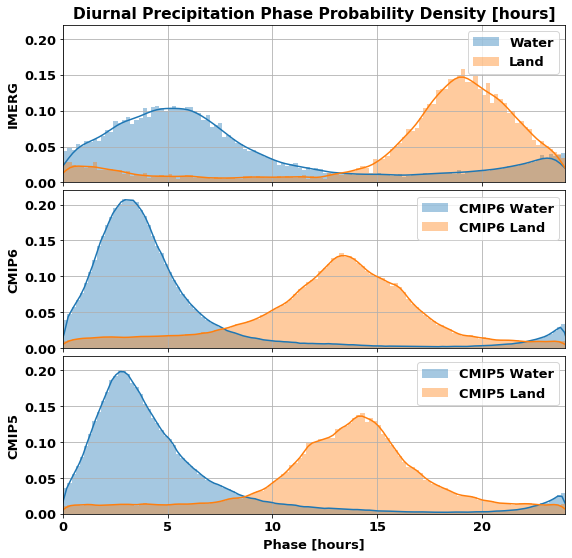

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [190]:
%run model_by_model_analysis_helper.py

fig, ax_hist = plt.subplots(3, 1, sharex = True, figsize = (9,9))

land_sea_histogram(df_gpm, 
                   ax = ax_hist[0],
                   title = 'Diurnal Precipitation Phase Probability Density [hours]',
                   ylabel = 'IMERG')

land_sea_histogram(df,
                   cmip_identifier= 'CMIP6',
                   ax = ax_hist[1],
                   ylabel = 'CMIP6')

land_sea_histogram(df,
                   cmip_identifier = 'CMIP5',
                   ax = ax_hist[2],
                   ylabel = 'CMIP5',
                   xlabel = 'Phase [Hour]')

fig.subplots_adjust(hspace=.05)

fig.savefig(save_figs_dir_paper + 'yearly_histogram.png', dpi = 300)



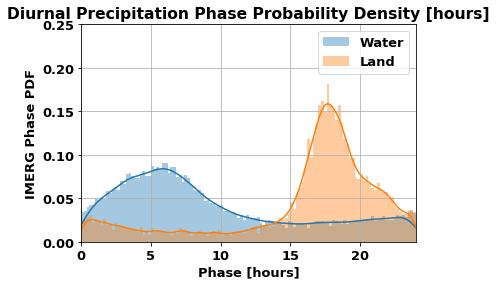

In [261]:
land_sea_histogram(filter_by_season(df_gpm, season_ii), 
                   title = 'Diurnal Precipitation Phase Probability Density [hours]',
                   ylabel = 'IMERG Phase PDF')

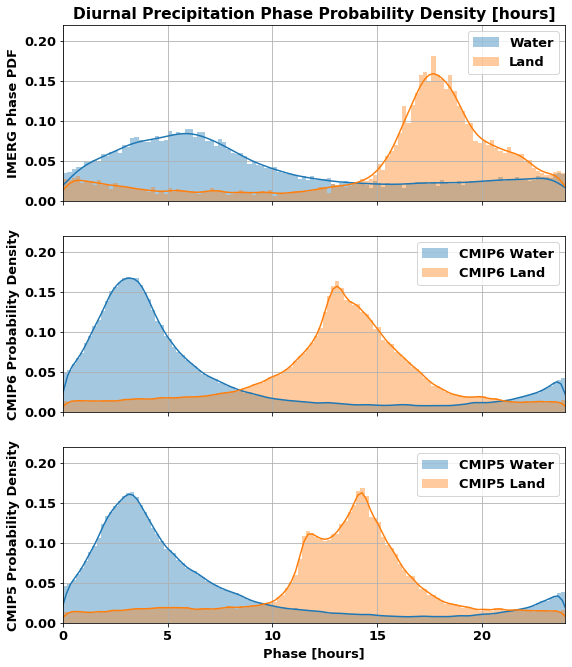

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [262]:
# land_sea_histogram(filter_by_season(df, 'JJA'), nbins = 50)
# land_sea_histogram(df_gpm, field_id = 'ampl_season', nbins = 30)



fig, ax_hist_season = plt.subplots(3, 1, sharex = True, figsize = (9,11))

season_ii = 'JJA'

land_sea_histogram(filter_by_season(df_gpm, season_ii), 
                   ax = ax_hist_season[0],
                   title = 'Diurnal Precipitation Phase Probability Density [hours]',
                   ylabel = 'IMERG Phase PDF')

land_sea_histogram(filter_by_season(df, season_ii),
                   cmip_identifier= 'CMIP6',
                   ax = ax_hist_season[1],
                   ylabel = 'CMIP6 Probability Density')

land_sea_histogram(filter_by_season(df, season_ii),
                   cmip_identifier = 'CMIP5',
                   ax = ax_hist_season[2],
                   ylabel = 'CMIP5 Probability Density',
                   xlabel = 'Phase [Hour]')

# fig.subplots_adjust(hspace=.05)

In [28]:
# make_four_panel(ds , 
#                 lats = ds['lat'].values, 
#                 lons = ds['lon'].values,
#                 vmin = 0, vmax = 24, 
#                 cmap = plt.get_cmap('twilight'),
#                 title = r'$\Phi$',
# #                 axis = plt.axis([220, 300, 10, 50]), 
#                 save_fig_path= None)

# compute error statistics


In [255]:
df_cmip6 = df[df['cmip_identifier'] == 'CMIP6']
df_cmip5 = df[df['cmip_identifier'] == 'CMIP5']
field = 'phase_season'
# season = 'DJF'
# df

df_for_stats = df_cmip5.copy()
df_for_stats_true = df_gpm.copy()

df_for_stats['ampl_season'] = FLUX_TO_MM_HR*df_for_stats['ampl_season']
df_for_stats['mu_season'] = FLUX_TO_MM_HR*df_for_stats['mu_season']
# df_for_stats = df_for_stats[df_for_stats['season'] == season]

df_for_stats_cmip5, df_for_stats_cmip6 = df_cmip5.copy(), df_cmip6.copy()
df_for_stats_cmip5['ampl_season'] = FLUX_TO_MM_HR*df_for_stats_cmip5['ampl_season']
df_for_stats_cmip6['ampl_season'] = FLUX_TO_MM_HR*df_for_stats_cmip6['ampl_season']

df_for_stats_land = df_for_stats[df_for_stats['land_sea_mask'] == 1]
df_for_stats_water = df_for_stats[df_for_stats['land_sea_mask'] == 0]

df_for_stats_true_land = df_for_stats_true[df_for_stats_true['land_sea_mask'] == 1]
df_for_stats_true_water = df_for_stats_true[df_for_stats_true['land_sea_mask'] == 0]



In [256]:
# df_for_stats_true = df_gpm[df_gpm['season'] == season]

# # compute precip weights
# df_for_stats_true['precip_weights'] = df_for_stats_true['mu_season']/df_for_stats_true['mu_season'].sum()

# # merge gpm precip weights into model df 
# df_for_stats = pd.merge(df_for_stats, 
#                         df_for_stats_true['precip_weights'], 
#                         how = 'left', 
#                         left_index = True, 
#                         right_index = True)


df_lat_lon_mean = df_for_stats.groupby(['lat','lon']).mean()
# df_lat_lon_mode_phase = df_for_stats.round(1).groupby(['lat','lon'])['phase_season'].agg(mode_apply)
# df_lat_lon_mode_ampl = df_for_stats.round(4).groupby(['lat','lon'])['ampl_season'].agg(mode_apply)

# df_lat_lon_err = df_lat_lon_mean - df_for_stats_true
df_lat_lon_err = circdiff(df_lat_lon_mean, df_for_stats_true)
cmips_err_ds = xr.Dataset.from_dataframe(df_lat_lon_err)
cmips_mean_ds = xr.Dataset.from_dataframe(df_lat_lon_mean)
# cmips_mode_df = pd.DataFrame()
# cmips_mode_df['phase_mode'] = df_lat_lon_mode_phase
# cmips_mode_df['ampl_mode'] = df_lat_lon_mode_ampl
# cmips_mode_ds = xr.Dataset.from_dataframe(cmips_mode_df)

# ampl_weighted_mean_df = df_for_stats[['ampl_season', 'precip_weights', 'model_name']].groupby('model_name').apply(ampl_weighted_mean_func)

# ampl_weighted_mean_df = df_for_stats[['ampl_season', 'model_name']].groupby('model_name').apply(ampl_weighted_mean_func)

df_lat_lon_mean_cmip5 = df_for_stats_cmip5.groupby(['lat','lon']).mean()
cmip5_mean_ds = xr.Dataset.from_dataframe(df_lat_lon_mean_cmip5)


df_lat_lon_mean_cmip6 = df_for_stats_cmip6.groupby(['lat','lon']).mean()
cmip6_mean_ds = xr.Dataset.from_dataframe(df_lat_lon_mean_cmip6)




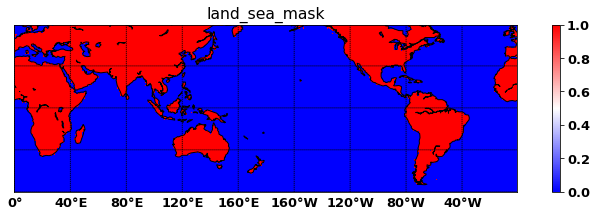

In [19]:
make_single_plot(ds_land_sea['GLDAS_mask'] ,
                 title = 'land_sea_mask',
                 vmin = 0, vmax = 1, 
                 cmap  =plt.get_cmap('bwr'))



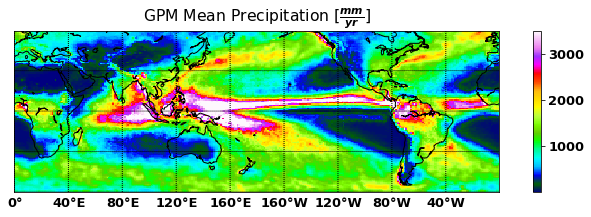

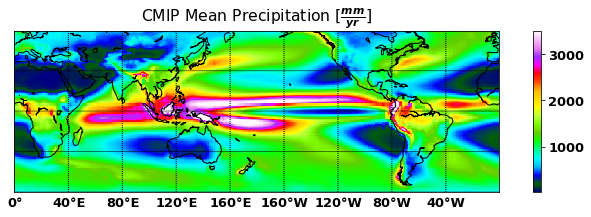

In [193]:

make_single_plot(ds_gpm['mu_season']*MM_HR_TO_MM_YR, 
                 title = r'GPM Mean Precipitation [$\frac{mm}{yr}$]',
                 cmap = plt.get_cmap('gist_ncar'), vmax = 0.4*MM_HR_TO_MM_YR)
# plt.savefig(save_figs_dir + 'GPM/' + 'mu_mean_spatial.png', dpi = 300)
make_single_plot(cmips_mean_ds['mu_season'] *MM_HR_TO_MM_YR, 
                 title = r'CMIP Mean Precipitation [$\frac{mm}{yr}$]',
                  cmap = plt.get_cmap('gist_ncar'), vmax = 0.4*MM_HR_TO_MM_YR)
# plt.savefig(save_figs_dir + 'CMIP6/all_models/' + 'mu_mean_spatial.png', dpi = 300)

# make_single_plot(cmips_mean_ds['mu_season'].where(cmips_mean_ds['mu_season'] > 0.04), 
#                  title = r'CMIP Mean Precipitation [$\frac{mm}{yr}$]',
#                   cmap = plt.get_cmap('gist_ncar'), vmax = 0.4)

In [112]:
ds_gpm['mu_season'].mean() - cmips_mean_ds['mu_season'].mean()

<xarray.DataArray 'mu_season' ()>
array(0.00112189)

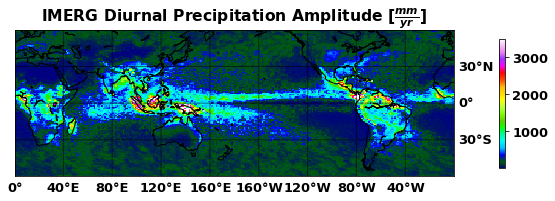

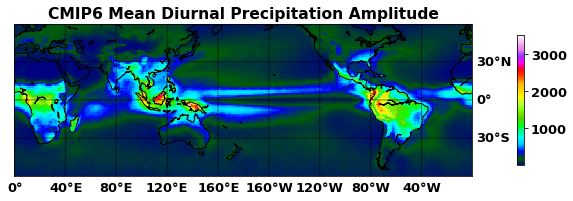

In [257]:
make_single_plot(ds_gpm['ampl_season']*MM_HR_TO_MM_YR, 
                 title = r'IMERG Diurnal Precipitation Amplitude [$\frac{mm}{yr}$]',
                 cmap = plt.get_cmap('gist_ncar'), vmax = 0.4*MM_HR_TO_MM_YR)
# plt.savefig(save_figs_dir + 'GPM/' + 'ampl_mean_spatial.png', dpi = 300)

make_single_plot(cmip6_mean_ds['ampl_season']*MM_HR_TO_MM_YR, 
                 title = r'CMIP6 Mean Diurnal Precipitation Amplitude',
                  cmap = plt.get_cmap('gist_ncar'), vmax = 0.4*MM_HR_TO_MM_YR)
# plt.savefig(save_figs_dir + 'CMIP6/all_models/' + 'ampl_mean_spatial.png', dpi = 300)

In [254]:
cmip6_mean_ds['ampl_season']

<xarray.DataArray 'ampl_season' (lat: 240, lon: 720)>
array([[1.77424907e-06, 1.77404718e-06, 1.84004412e-06, ...,
        1.82657440e-06, 1.80053514e-06, 1.77874803e-06],
       [1.78115941e-06, 1.78492269e-06, 1.85814124e-06, ...,
        1.83049625e-06, 1.80570691e-06, 1.78391980e-06],
       [1.78255370e-06, 1.78631697e-06, 1.85379687e-06, ...,
        1.83571705e-06, 1.81092772e-06, 1.78531409e-06],
       ...,
       [2.59111304e-06, 2.63660300e-06, 2.68212917e-06, ...,
        2.23492876e-06, 2.34699876e-06, 2.56657805e-06],
       [2.59310149e-06, 2.54652297e-06, 2.54798813e-06, ...,
        2.43032057e-06, 2.47792103e-06, 2.57486606e-06],
       [2.60444531e-06, 2.55786679e-06, 2.55200124e-06, ...,
        2.42137776e-06, 2.46897822e-06, 2.58620988e-06]])
Coordinates:
  * lat      (lat) float64 -60.0 -59.5 -59.0 -58.5 -58.0 ... 58.0 58.5 59.0 59.5
  * lon      (lon) float64 0.0 0.5 1.0 1.5 2.0 ... 357.5 358.0 358.5 359.0 359.5

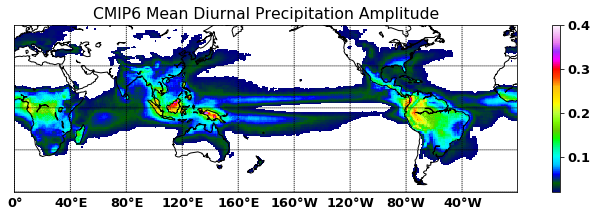

In [108]:
make_single_plot(cmips_mean_ds['ampl_season'].where(cmips_mean_ds['ampl_season']> 0.02), 
                 title = r'CMIP6 Mean Diurnal Precipitation Amplitude',
                  cmap = plt.get_cmap('gist_ncar'), vmax = 0.4)

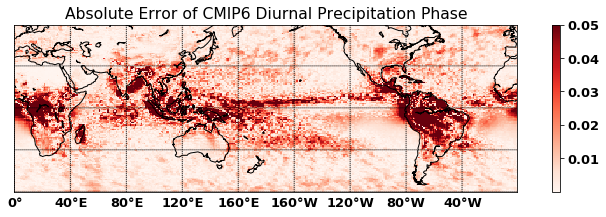

In [109]:
make_single_plot(cmips_err_ds['ampl_season'], 
                 title = r'Absolute Error of CMIP6 Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('Reds'),vmax = 0.05)
# plt.savefig(save_figs_dir + 'compare_models/' + 'ampl_abs_error_spatial.png', dpi = 300)

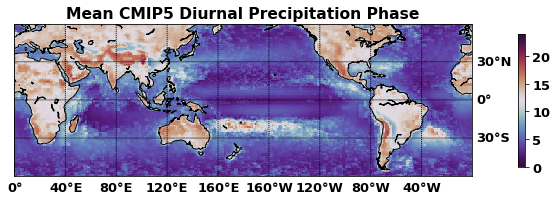

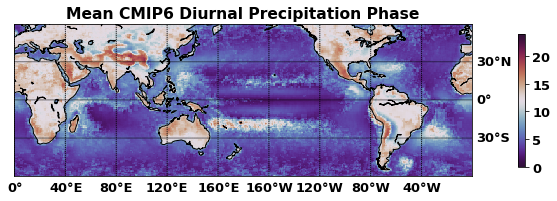

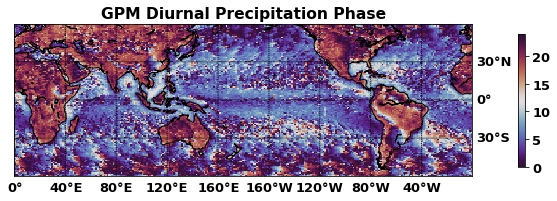

In [247]:
# # plot mean
make_single_plot(cmip5_mean_ds['phase_season'], 
                 title = r'Mean CMIP5 Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)
# isinstance(cmips_mean_ds[field])
# plt.savefig(save_figs_dir + 'CMIP6/all_models/' + 'phase_mean_spatial.png', dpi = 300)

make_single_plot(cmip6_mean_ds['phase_season'], 
                 title = r'Mean CMIP6 Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)

make_single_plot(ds_gpm['phase_season'], 
                 title = r'GPM Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)
# plt.savefig(save_figs_dir + 'GPM/' + 'phase_mean_spatial.png', dpi = 300)
# isinstance(cmips_mean_ds[field])
# plt.savefig(save_figs_dir + 'CMIP6/all_models/' + 'phase_mean_spatial.png', dpi = 300)

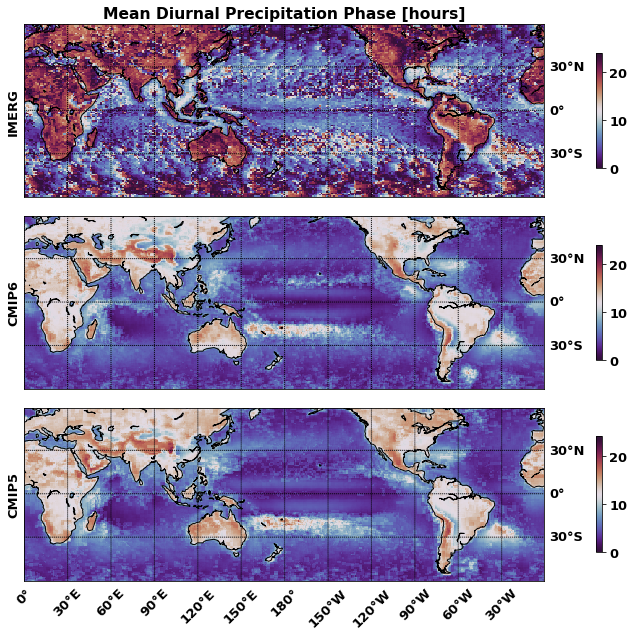

In [281]:
%run diurnal_utils.py


fig, ax_hist = plt.subplots(3, 1, sharex = True, figsize = (9,9))


make_single_plot(ds_gpm['phase_season'], 
                 title = r'Mean Diurnal Precipitation Phase [hours]',
                 ax = ax_hist[0],
                 fig = fig,
                 ylabel = 'IMERG', 
                 xticks_bool = False,
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)

make_single_plot(cmip6_mean_ds['phase_season'], 
#                  title = r'Mean CMIP6 Diurnal Precipitation Phase',
                 title = None,
                 ax = ax_hist[1],
                 fig = fig,
                 ylabel = 'CMIP6',
                 xticks_bool = False,
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)

make_single_plot(cmip5_mean_ds['phase_season'], 
#                  title = r'Mean Diurnal Precipitation Phase',
                 title = None, 
                 ax = ax_hist[2],
                 fig = fig,
                 ylabel = 'CMIP5',
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)




fig.subplots_adjust(hspace=.01)
fig.savefig(save_figs_dir_paper + 'phase_mean_spatial_yearly.png', dpi = 300)



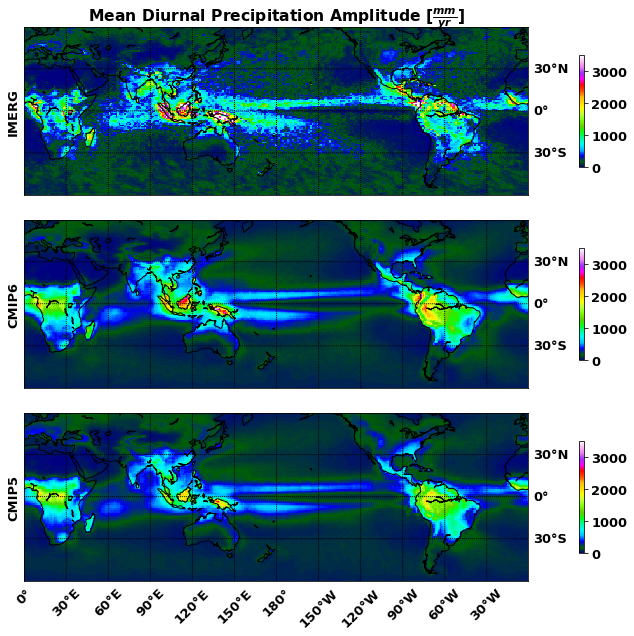

In [282]:
fig, ax_hist = plt.subplots(3, 1, sharex = True, figsize = (9,9))


make_single_plot(ds_gpm['ampl_season']*MM_HR_TO_MM_YR, 
                 title = r'Mean Diurnal Precipitation Amplitude [$\frac{mm}{yr}$]',
                 ax = ax_hist[0],
                 fig = fig,
                 ylabel = 'IMERG', 
                 xticks_bool = False,
                 cmap = plt.get_cmap('gist_ncar'),
                 vmin = 0, vmax = 0.4*MM_HR_TO_MM_YR)

make_single_plot(cmip6_mean_ds['ampl_season']*MM_HR_TO_MM_YR, 
#                  title = r'Mean CMIP6 Diurnal Precipitation Phase',
                 title = None,
                 ax = ax_hist[1],
                 fig = fig,
                 ylabel = 'CMIP6',
                 xticks_bool = False,
                 cmap = plt.get_cmap('gist_ncar'),
                 vmin = 0, vmax = 0.4*MM_HR_TO_MM_YR)

make_single_plot(cmip5_mean_ds['ampl_season']*MM_HR_TO_MM_YR, 
#                  title = r'Mean Diurnal Precipitation Phase',
                 title = None, 
                 ax = ax_hist[2],
                 fig = fig,
                 ylabel = 'CMIP5',
                 cmap = plt.get_cmap('gist_ncar'),
                 vmin = 0, vmax = 0.4*MM_HR_TO_MM_YR)

fig.subplots_adjust(hspace=.01)

fig.savefig(save_figs_dir_paper + 'ampl_mean_spatial_yearly.png', dpi = 300)

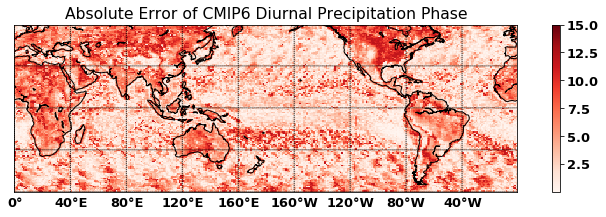

In [32]:
# cmips_err_ds[field].plot.imshow(cmap = plt.get_cmap('gist_ncar'), vmin = -5, vmax = 5)
# cmips_err_ds[field].plot.imshow(cmap = plt.get_cmap('seismic_r'))
make_single_plot(cmips_err_ds['phase_season'], 
                 title = r'Absolute Error of CMIP6 Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('Reds'), vmax = 15)
#                  vmin = 0, vmax = 3)
# plt.savefig(save_figs_dir + 'compare_models/' + 'phase_abs_error_spatial.png', dpi = 300)

# Taylor Plots

In [95]:
# gpm_std = df_gpm[field].std()
gpm_std =  circstd(df_gpm['phase_season'], low = 0.0, high = 24.0)
gpm_land_std = circstd(df_gpm_land['phase_season'], low = 0.0, high = 24.0)
gpm_water_std = circstd(df_gpm_water['phase_season'],low = 0.0, high = 24.0)

# # calculate obs ampl
# obs_water_std = hour_circstd(obs_water_df['phase_season'])
# obs_land_std = hour_circstd(obs_land_df['phase_season'])


In [249]:
# input_data_dir_rlut
# mean_fields_to_rel_path_map

{'rlut': '/export/data1/cchristo/CMIP6_radiation/averages/time_averages/period/rlut_regridded/grid1/',
 'rsut': '/export/data1/cchristo/CMIP6_radiation/averages/time_averages/period/rsut_regridded/grid1/',
 'pr': '/export/data1/cchristo/CMIP6_precip/averages/time_averages/period/pr_regridded/grid1/',
 'clt': '/export/data1/cchristo/CMIP6_clouds/averages/time_averages/period/clt_regridded/grid1/'}

In [ ]:
# os.listdir(input_data_dir_rlut)
%run model_by_model_analysis_helper.py

In [80]:


%run model_by_model_analysis_helper.py

# tropics
# min_lat, max_lat = -30, 30
# field_means_df = _get_mean_fields(field_names = ['rlut','rsut', 'pr', 'clt'],
#                        mean_fields_to_rel_path_map = mean_fields_to_rel_path_map,
#                        filter_by_lat = True,
#                        **{'min_lat': min_lat,
#                        'max_lat': max_lat})


# # tropics water
min_lat, max_lat = -60, 60
field_means_df = _get_mean_fields(field_names = ['rlut','rsut', 'pr', 'clt'],
                      mean_fields_to_rel_path_map = mean_fields_to_rel_path_map,
                      file_name = 'grid1_1985-01_2006-01_mean.nc',
                      filter_lat = True,
                      landsea_mask_df = df_land_sea,
                      landsea_bool = 0,
                       **{'min_lat': min_lat,
                          'max_lat': max_lat,
                          'absolute_value': False})
# subtropics
# min_lat, max_lat = 30, 60
# min_lat, max_lat = -30, 30

# field_means_df = _get_mean_fields(field_names = ['rlut','rsut', 'pr', 'clt'],
#                        mean_fields_to_rel_path_map = mean_fields_to_rel_path_map,
#                        filter_lat = True,
#                        **{'min_lat': min_lat,
#                           'max_lat': max_lat,
#                           'absolute_value': True})


# rr = _get_mean_field(field_name = 'rsut',
#                       data_dir = mean_fields_to_rel_path_map['rsut'],
#                       file_name = 'grid1_1985-01_2006-01_mean.nc',
#                       filter_lat = True,
#                       landsea_mask_df = df_land_sea,
#                       landsea_bool = 0,
#                        **{'min_lat': min_lat,
#                           'max_lat': max_lat,
#                           'absolute_value': False})




# stats_kwargs = {'ecs_dict': cmip6_ecs, 'tcr_dict': cmip6_tcr, 
#      'rlut_dict': rlut_dict, 'rsut_dict': rsut_dict, 
#      'pr_dict': pr_dict, 'clt_dict': clt_dict}

In [304]:
# field_means_df

In [283]:
%run model_by_model_analysis_helper.py




In [48]:
# df_for_stats[df_for_stats['mu_season'] > 0.1]



In [98]:
# compute stats for all points
# df_for_stats[df_for_stats['ampl_season']> 0.001
%run model_by_model_analysis_helper.py
# model_error_stats_df= compute_stats(df_for_stats,
#                  df_for_stats_true,
#                  field = 'phase_season',
#                  agg_method = 'mode',
#                  error_stats = True,
#                  additional_stats = True,)                

model_error_stats_df_land = compute_stats(df_for_stats_land,
                 df_for_stats_true_land,
                 field = 'phase_season',
                 agg_method = 'mode',
                 additional_stats = True,)


### compute stats for land/water
model_error_stats_df_water = compute_stats(df_for_stats_water,
                 df_for_stats_true_water,
                 agg_method = 'mode',
                 field = 'phase_season',
                 additional_stats = True,)


# model_error_stats_df_water = compute_stats(filter_by_lat(df_for_stats_water, min_lat, max_lat),
#                  filter_by_lat(df_for_stats_true_water, min_lat, max_lat),
#                  agg_method = 'mode',
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  **stats_kwargs)

# model_error_stats_df_land = compute_stats(df_for_stats_land,
#                  df_for_stats_true_land,
#                  agg_method = 'mode',
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  **stats_kwargs)

####### compute stats for given latitude range
# min_lat, max_lat = -60, 60
# # # # min_lat, max_lat = 30, 60
# # # # min_lat, max_lat = 0, 60

# # # # min_lat, max_lat = 30, 60
# absolute_values = False

# # # print(min_lat, max_lat)
# # df_for_stats_filt = filter_by_lat(df_for_stats, min_lat, max_lat, absolute_value=False)
# # df_for_stats_true_filt = filter_by_lat(df_for_stats_true, min_lat, max_lat, absolute_value=False)


# df_for_stats_filt_land = filter_by_lat(df_for_stats_land, min_lat, max_lat, absolute_value=absolute_values)
# df_for_stats_true_filt_land = filter_by_lat(df_for_stats_true_land, min_lat, max_lat, absolute_value=absolute_values)


# df_for_stats_filt_water = filter_by_lat(df_for_stats_water, min_lat, max_lat, absolute_value=absolute_values)
# df_for_stats_true_filt_water = filter_by_lat(df_for_stats_true_water, min_lat, max_lat, absolute_value=absolute_values)



# # model_error_stats_df = compute_stats(df_for_stats_filt,
# #                  df_for_stats_true_filt,
# #                  agg_method = 'mean',
# #                  field = 'phase_season',
# #                  additional_stats = True, 
# #                  **stats_kwargs)
                

    
    

# model_error_stats_df_water = compute_stats(df_for_stats_filt_water,
#                  df_for_stats_true_filt_water,
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  agg_method = 'mode',)

# model_error_stats_df_land = compute_stats(df_for_stats_filt_land,
#                  df_for_stats_true_filt_land,
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  agg_method = 'mode',)

In [81]:

### select season
# season_ii = 'DJF'
# df_for_analysis = model_error_stats_df_water
# df_for_analysis = df_for_analysis.reset_index('season')
# df_for_analysis = df_for_analysis[df_for_analysis['season'] == season_ii]


### yearly mean
df_for_analysis = model_error_stats_df_water

merge_sensitivities = pd.merge(df_for_analysis, cmip5_sensitivities, 
         how = 'left',
         left_index = True, 
         right_index = True)
all_stats_df = pd.merge(merge_sensitivities, field_means_df,
         how = 'left',
         left_index = True, 
         right_index = True)d

In [120]:
%run model_by_model_analysis_helper.py

In [62]:
save_fig_corr_heatmap_dir = '/home/cchristo/proj_tapio/diurnal_research/figs/diurnal_cycle_figs/corr_heatmaps/CMIP6/' 

## Make Correlation Heatmap

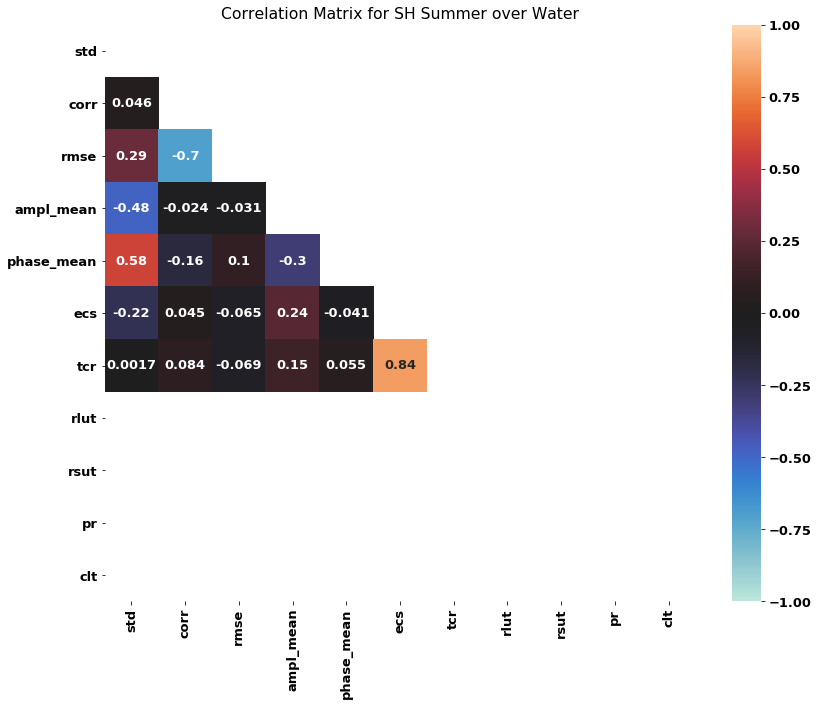

In [82]:

corr_mat_ds = all_stats_df

plot_corr_matrix(corr_mat_ds, 
                 title = 'Correlation Matrix for SH Summer over Water')
# plt.savefig(save_fig_corr_heatmap_dir + 'DJF_mode_sh_water.png', dpi = 250)

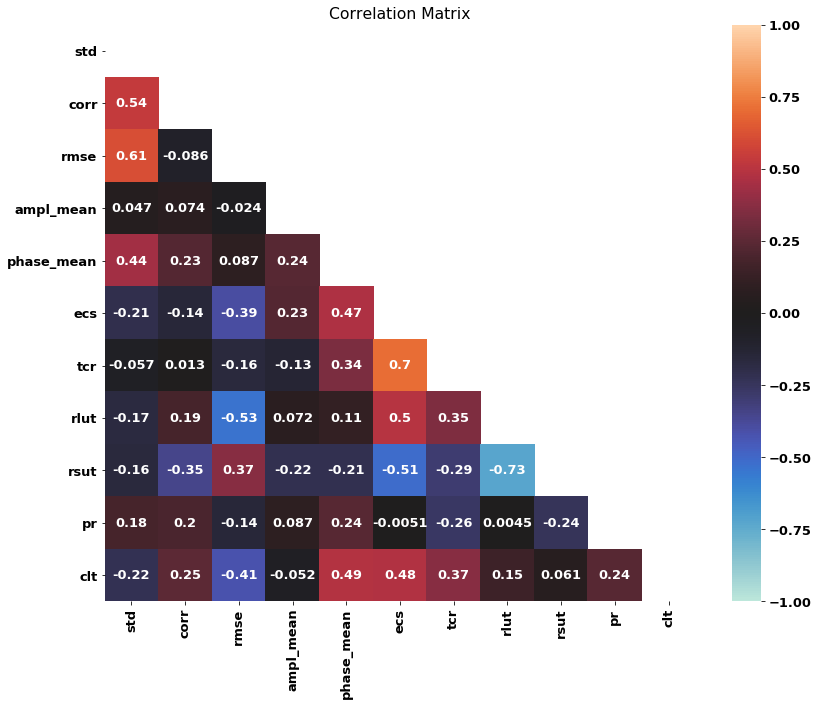

In [159]:
# model_error_stats_df #.reset_index('season')

corr_mat_ds = all_stats_df
# .drop(['IPSL-CM6A-LR']) #.drop(['BCC-CSM2-MR']) #.drop(['GFDL-ESM2M', 'MIROC5'])

# mes_df_season = model_error_stats_df.reset_index('season')
# mes_df_season = mes_df_season[mes_df_season['season'] == 'JJA']

# corr_mat_ds = mes_df_season

# plt.figure(figsize = (12,10))
# plt.title('Correlation Matrix for All Latitudes [Method: mode]')
# upper_tr_mask = np.triu(corr_mat_ds.corr())
# sns.heatmap(corr_mat_ds.corr(), annot = True, 
#             vmin = -1, vmax = 1, center = 0, fmt='.2g',
#             mask = upper_tr_mask)

# plt.tight_layout()
plot_corr_matrix(corr_mat_ds)
# plt.savefig(save_figs_dir + 'corr_heatmaps/CMIP6/' + 'land_and_water_poleward_of_35.png', dpi = 300)

In [94]:
# model_error_stats_df
# model_error_stats_df.sort_values('rmse')

In [84]:
def metric_scatter(df, x_field = 'phase_mean', 
                   y_field = 'ecs',
                   xlabel = 'Phase Mean [Hours]',
                   ylabel = 'ECS',
                   figsize = (8,5),
                   annotate_bool = True):
    plt.figure(figsize = figsize)
    # for mod_ii in model_error_stats_df.iterrows():
    model_list = list(df.index)
    for ii in range(len(df)):
        mod_ii = df.iloc[ii,:]
        xx,yy = mod_ii[x_field], mod_ii[y_field]
        if (not np.isnan(xx)) & (not np.isnan(yy)):
            plt.plot(xx, yy, 'o', label = str(ii) + ': ' + model_list[ii])
            plt.annotate(str(ii), (xx, yy), size = 9, weight = 'bold')
    plt.grid()
    plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5),prop={'size': 8})
    if xlabel:
        plt.xlabel(xlabel, weight = 'bold')
        
    if ylabel:
        plt.ylabel(ylabel, weight = 'bold')
    
    corr = df.corr()[x_field][y_field]
    print(corr)
    if annotate_bool:
        plt.annotate('Corr:' + '{:.3f}'.format(corr), 
                     xy=(0.75, 0.01), xycoords='axes fraction')


    plt.tight_layout()

In [83]:

# metric_scatter(model_error_stats_df_land)
# plt.title('CMIP6 ECS vs. Diurnal Phase Land', weight = 'bold')
# # plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'ecs_vs_phase_land.png', dpi = 300)


metric_scatter(all_stats_df)
plt.title('CMIP6 ECS vs. Diurnal Phase Water', weight = 'bold')
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'ecs_vs_phase_water_25n_25_s.png', dpi = 300)

# metric_scatter(model_error_stats_df_land, y_field = 'tcr')
# plt.title('CMIP6 TCR vs. Diurnal Phase Land', weight = 'bold')
# plt.ylabel('TCR')
# # plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'tcr_vs_phase_land.png', dpi = 300)


# metric_scatter(model_error_stats_df_water, y_field = 'tcr')
# plt.title('CMIP6 TCR vs. Diurnal Phase Water', weight = 'bold')
# plt.ylabel('TCR')
# # plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'tcr_vs_phase_water.png',  dpi = 300)



NameError: name 'metric_scatter' is not defined

In [148]:
# all_stats_df

-0.0413181292459667


(array([1., 2., 3., 4., 5., 6.]), <a list of 6 Text xticklabel objects>)

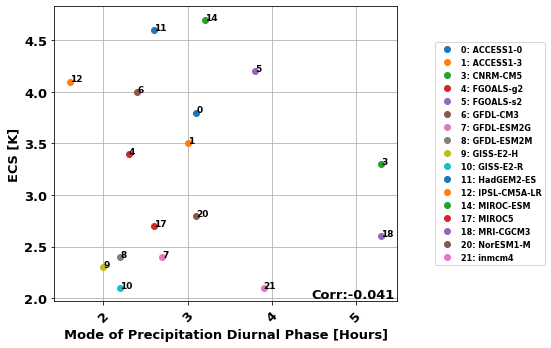

In [92]:
# plt.figure(figsize = (7,10))
metric_scatter(all_stats_df,  
               x_field = 'phase_mean',  
               y_field = 'ecs',
               xlabel = 'Mode of Precipitation Diurnal Phase [Hours]',
               ylabel = 'ECS [K]',
               figsize = (8,5), 
               annotate_bool=True)
# plt.title('CMIP6 ECS vs. Diurnal Phase over Water', weight = 'bold')

# plt.ylabel(r'SWR [$\frac{W}{m^2}$]')
# plt.ylabel
# plt.xlabel('Diurnal Phase of Precipitation (mean)')
plt.xticks(rotation=45)
# plt.xlim([2.5, 4.5])
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'ecs_vs_phase_water_new.png', dpi = 300)




0.7022688628059023


Text(0.5, 1, 'CMIP6 ECS vs. Diurnal Phase over Water')

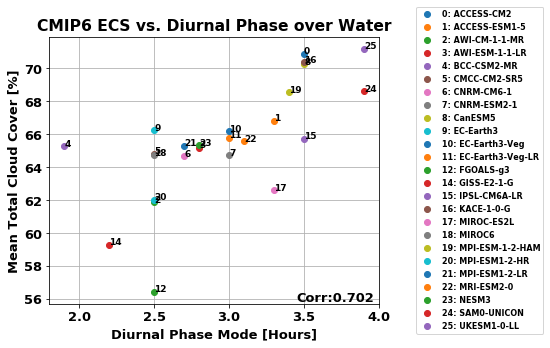

In [205]:
# sanity check modes
# mode_apply(df_cmip5[df_cmip5['model_name'] == 'GFDL-ESM2G'].round(1)['phase_season'])

metric_scatter(all_stats_df,  
               y_field = 'clt', 
               x_field = 'phase_mean',
               xlabel = 'Diurnal Phase Mode [Hours]',
               ylabel = 'Mean Total Cloud Cover [%]',)
plt.title('CMIP6 ECS vs. Diurnal Phase over Water', weight = 'bold')

0.6734658754585652


Text(0.5, 1, 'CMIP6 Mean Outgoing Shortwave Radiation vs. Diurnal Amplitude')

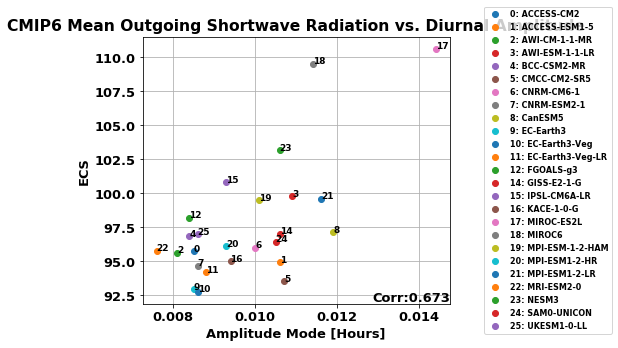

In [207]:
metric_scatter(all_stats_df,  
               y_field = 'rsut', x_field = 'ampl_mean',
               xlabel = 'Amplitude Mode [Hours]')
plt.title('CMIP6 Mean Outgoing Shortwave Radiation vs. Diurnal Amplitude', weight = 'bold')
# plt.xlim([2.5, 4.5])
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP5/' + 'ecs_vs_ampl_water.png', dpi = 300)




In [248]:
# metric_scatter(model_error_stats_df,  y_field = 'rlut', x_field = 'rsut')
# plt.title('CMIP6 ECS vs. Diurnal Phase Water', weight = 'bold')
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP5/' + 'ecs_vs_ampl_water.png', dpi = 300)





0.6939125146384588


Text(0.5, 1, 'CMIP6 Clt vs. ECS')

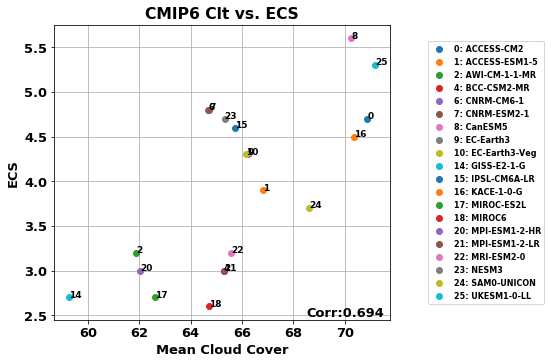

In [213]:
metric_scatter(all_stats_df, x_field = 'clt', y_field = 'ecs' )
plt.xlabel('Mean Cloud Cover')
plt.ylabel('ECS')
plt.title('CMIP6 Clt vs. ECS', weight = 'bold')
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/' + 'ecs_vs_tcr_cmip6.png',  dpi = 300)



In [38]:
# Create Taylor Diagram
# import taylorDiagram
# %%capture
%run taylorDiagram.py

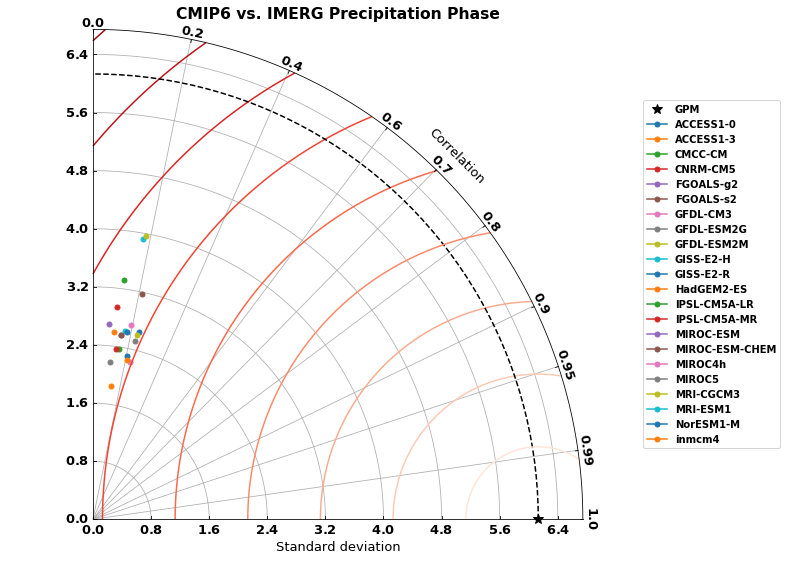

In [101]:
fig = plt.figure(figsize = (13,8))
# plt.title('Test')
taylor_diag = taylorDiagram.TaylorDiagram(gpm_std, 
                                          fig = fig, 
                                          label = 'GPM', 
                                          extend = False,
                                          srange=(0, 1.1)
                                          )
taylor_diag.add_contours(cmap = plt.get_cmap('Reds'), levels = 10)
taylor_diag.add_grid()

for model_name in list(model_error_stats_df_water.index):
#     print(model_error_stats[model_name])
    taylor_diag.add_sample(stddev = model_error_stats_df_water.loc[model_name,:]['std'], 
                           corrcoef = model_error_stats_df_water.loc[model_name,:]['corr'], 
                           marker = '.', 
                           label = model_name, 
                           markersize = 10)

# plt.legend()
plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5), prop={'size': 10})
plt.title('CMIP6 vs. IMERG Precipitation Phase', weight = 'bold')
plt.tight_layout()
# plt.savefig(save_figs_dir + 'compare_models/taylor_plots/' + 'all_cmip5_water.png', dpi = 300)

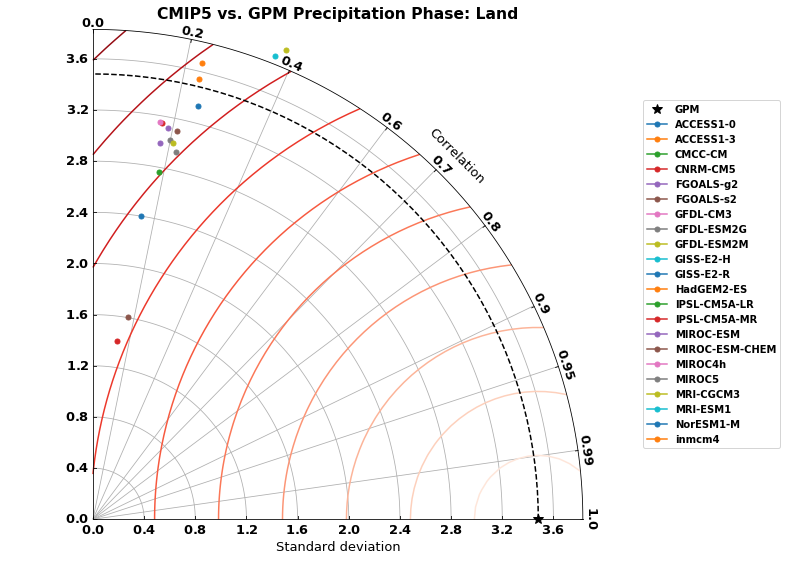

In [96]:
fig = plt.figure(figsize = (13,8))
# plt.title('Test')
taylor_diag = taylorDiagram.TaylorDiagram(gpm_land_std, 
                                          fig = fig, 
                                          label = 'GPM', 
                                          extend = False,
                                          srange=(0, 1.1)
                                          )
taylor_diag.add_contours(cmap = plt.get_cmap('Reds'), levels = 10)
taylor_diag.add_grid()

for model_name in list(model_error_stats_df_land.index):
#     print(model_error_stats[model_name])
    taylor_diag.add_sample(stddev = model_error_stats_df_land.loc[model_name,:]['std'], 
                           corrcoef = model_error_stats_df_land.loc[model_name,:]['corr'], 
                           marker = '.', 
                           label = model_name, 
                           markersize = 10)

# plt.legend()
plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5), prop={'size': 10})
plt.title('CMIP5 vs. GPM Precipitation Phase: Land', weight = 'bold')
plt.tight_layout()

# plt.savefig(save_figs_dir + 'compare_models/taylor_plots/' + 'all_cmip5_land.png', dpi = 300)

In [93]:
# mode_apply(df_for_stats_true_water['phase_season'])
# df_for_stats_true.plot(x = 'ampl_season', y = 'phase_season' , kind = 'scatter')
# sns.jointplot('ampl_season', 'phase_season', data = df_for_stats_true, 
#               kind = 'hex', xlim = [0, 0.2])
# _ = plt.hist2d(df_for_stats_true['ampl_season'], df_for_stats_true['phase_season'], bins = 300,
#               density = True, cmap = plt.get_cmap('gist_ncar'))
# plt.xlim([0, 0.2])
# plt.colorbar()

In [169]:
%run phaseDiagram.py
%run model_by_model_analysis_helper.py



make_phase_plot(model_error_stats_df_water,
                model_error_stats_df_land,
                df_for_stats_true_land, 
                df_for_stats_true_water,
               )

TypeError: __init__() missing 1 required positional argument: 'refstd'

<Figure size 936x576 with 0 Axes>

Text(0.5, 1.05, 'Diurnal Phase [hr] & Amplitude [$\\frac{mm}{yr}$] for CMIP5 and IMERG')

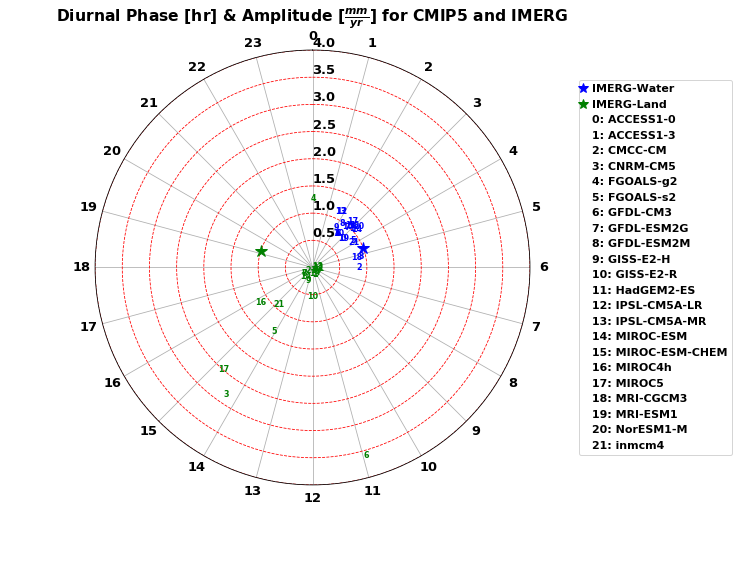

In [164]:
%run phaseDiagram.py

fig = plt.figure(figsize = (13,8))
# plt.title('Test')

markersize = 2
textsize = 8
normalize_ampl = True

ampl_unit_conversion_factor = MM_HR_TO_MM_YR
taylor_diag = PhaseDiagram(
                          fig = fig, 
                          label = 'IMERG', 
                          y_lim=(0, 4),
                          radial_label_pos = 0
                          )
taylor_diag.add_grid()

ampl_observed_water = mode_apply(df_for_stats_true_water['ampl_season'].round(4)* ampl_unit_conversion_factor)
ampl_observed_land = mode_apply(df_for_stats_true_land['ampl_season'].round(4)* ampl_unit_conversion_factor)

if normalize_ampl:
    ampl_to_plot_water = 1.0
    ampl_to_plot_land = 1.0
else:
    ampl_to_plot_water = ampl_observed_water
    ampl_to_plot_land = ampl_observed_land
    
taylor_diag.add_sample(phase = mode_apply(df_for_stats_true_water['phase_season'].round(1)), 
                           ampl = ampl_to_plot_water, 
                           marker = '*', 
                           c = 'b',
                           label = 'IMERG-Water', 
                           markersize = 13)

taylor_diag.add_sample(phase = mode_apply(df_for_stats_true_land['phase_season'].round(1)), 
                           ampl = ampl_to_plot_land, 
                           marker = '*', 
                           c = 'g',
                           label = 'IMERG-Land', 
                           markersize = 13)


## Plot model phase/ampl over water
model_list = list(model_error_stats_df_water.index)
for model_name_i in range(len(model_list)):

    phase_i = model_error_stats_df_water.loc[model_list[model_name_i],:]['phase_mean']
    ampl_i = model_error_stats_df_water.loc[model_list[model_name_i],:]['ampl_mean'] * ampl_unit_conversion_factor

    if normalize_ampl:
        ampl_i = ampl_i/ampl_observed_water
    taylor_diag.add_sample(phase = phase_i, 
                           ampl = ampl_i, 
                           marker = None,
                           linestyle = None,
                           c = 'b',
                           label = str(model_name_i) + ': ' + model_list[model_name_i], 
                           markersize = markersize)
    taylor_diag.add_text(phase = phase_i, 
                         ampl = ampl_i,
                         text = model_name_i,
                         label = str(model_name_i) + ': ' + model_list[model_name_i], 
                         c = 'b',
                         size = textsize,
                         weight = 'bold')
    
## Plot model phase/ampl over land
for model_name_i in range(len(model_list)):
    phase_i = model_error_stats_df_land.loc[model_list[model_name_i],:]['phase_mean']
    ampl_i = model_error_stats_df_land.loc[model_list[model_name_i],:]['ampl_mean'] * ampl_unit_conversion_factor
    
    if normalize_ampl:
        ampl_i = ampl_i/ampl_observed_land
        
    taylor_diag.add_sample(phase = phase_i, 
                           ampl = ampl_i, 
                           marker = None, 
                           c = 'g',
                           linestyle = None,
#                            label = str(model_name_i) + ': ' + model_list[model_name_i], 
                           label = None,
                           markersize = markersize)
    taylor_diag.add_text(phase = phase_i, 
                         ampl = ampl_i,
                         text = model_name_i,
                         c = 'g',
                         size = textsize,
                         weight = 'bold')



leg = plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5), prop={'size': 11}, handlelength = 0, markerscale = 0.8)

    
plt.title(r'Diurnal Phase [hr] & Amplitude [$\frac{mm}{yr}$] for CMIP5 and IMERG', weight = 'bold')
# plt.title(r'Diurnal Phase [hr] & Amplitude [$\frac{mm}{hr}$] : CMIP6 vs. GPM Poleward of 35 N/S (Method: mode)', weight = 'bold')
# plt.tight_layout()

# plt.savefig(save_figs_dir + 'phase_ampl_plots/CMIP6/' + 'all_cmip6_land_water_pw_35NS.png', dpi = 300)

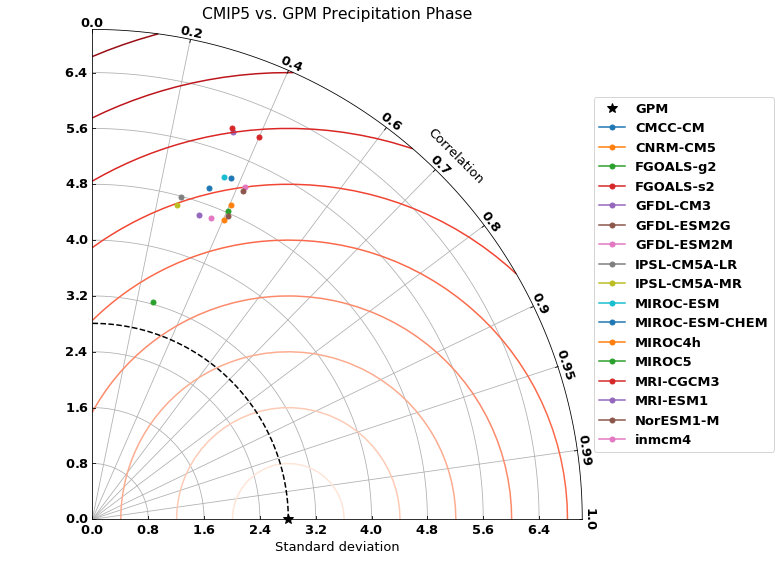

In [165]:
fig = plt.figure(figsize = (13,8))
# plt.title('Test')
taylor_diag = taylorDiagram.TaylorDiagram(gpm_std, 
                                          fig = fig, 
                                          label = 'GPM',
                                           srange=(0, 2.5))
taylor_diag.add_contours(cmap = plt.get_cmap('Reds'), levels = 10)
taylor_diag.add_grid()

for model_name in list(model_error_stats.keys()):
#     print(model_error_stats[model_name])
    taylor_diag.add_sample(stddev = model_error_stats[model_name][0], 
                           corrcoef = model_error_stats[model_name][1], 
                           marker = '.', 
                           label = model_name, 
                           markersize = 10)

# plt.legend()
plt.legend(loc = 'center left', bbox_to_anchor=(1,0.5))

plt.title('CMIP5 vs. GPM Precipitation Phase')
plt.tight_layout()
plt.savefig(save_figs_dir + 'compare_models/taylor_plots/' + 'all_cmip5.png', dpi = 300)